## Google Colab Setup. When running locally, skip these cells

I ran this notebook in Google Colab Pro in the Python3 environment using a GPU runtime for best performance.

At the time of writing, it was necessary to update the `tensorflow_datasets` package to import the data correctly. After running this cell, the runtime will restart after pressing the button that pops up prompting you to do so.

In [ ]:
!pip install tensorflow_datasets==4.2.0

These cells adapted from code located [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228)

In [ ]:
# Ensuring we're connected to a GPU

from tensorflow.test import gpu_device_name

device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

In [ ]:
# Change to the directory containing project files
PROJECT_PATH = '/content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone'

%cd '{PROJECT_PATH}'

In [ ]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

---

## Importing Libraries

In [1]:
# Import datascience packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import tensorflow packages
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### Run this cell when working locally. When using Colab, the import of this library is handled above.

In [2]:
# pcamlib.py is my library of helper functions
import pcamlib

----

## Data Set-up

In [3]:
# Load dataset and dataset info 
# This step takes about 15-20 minutes on Colab because it has to download the dataset first
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits=

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

In [4]:
# Create generator "pipelines" for train, validation and test sets.
# Default batch sizes of 64 for the train set and 128 for validation and test sets to speed up calculations
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## Modelling

### If you are not training this model and are loading it from a file, skip ahead to Loading the Model

I also used Geert Litjens CNN layer architecture as a starting point. It resembles a VGG16 architecture because it has three sets of two Convolutional layers followed by a single Max Pooling layer, followed by a Flattening layer and two Dense layers before the final Dense layer which outputs the class predictions. I kept the layer parameters the same as his example.

I changed the optimizer to `Adam` from `SGD` simply because he provided multiple hyperparameters to go along with it, and I wanted to experiment with that on my own. I also added additional Dropout layers after each convolutional layer, because the first iteration of the model started overfitting quickly after the first epoch and the validation accuracy didn't improve beyond 80%.

In [5]:
# Instantiate model object
cnn = Sequential()

# Images are 96x96 px, in RGB so there are 3 channels
image_shape = (96, 96, 3)

# Adding convultional layers to the model 
# It was important to add dropout layers after each convolutional layer to reduce overfitting
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=image_shape))
cnn.add(Dropout(0.4))
cnn.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.4))

# Add a max pool layer to reduce the dimensions of the feature maps
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Repeating this architecture two more times
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.4))
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.4))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
     
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.4))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='valid'))
cnn.add(Dropout(0.4))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))

# Flatten the data to prepare for dense layers
cnn.add(Flatten())
        
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.4))

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.4))

# Final Dense layer to make class predictions
cnn.add(Dense(2, activation='softmax'))
        
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 94, 94, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 92, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 44, 32)        0

In [6]:
# For comparison, this commented line is the original optimizer used in the article:
# sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
# opt = Adam(lr=0.001)
cnn.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stop callback to prevent the model from overfitting, or running too long
# This will stop the training early if the validation loss doesn't not decrease within 3 consecutive epochs
early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min', verbose=1)

In [7]:
%%time
history = cnn.fit(train_pipeline,
                   validation_data=valid_pipeline,
                   verbose=1, epochs=30, steps_per_epoch=4096, validation_steps=256,
                   callbacks=[early_stop])

Epoch 1/30
   2/4096 [..............................] - ETA: 16:58 - loss: 0.7709 - accuracy: 0.5703

KeyboardInterrupt: 

In [8]:
# Save the history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

NameError: name 'history' is not defined

---

## Saving Model and History

In [ ]:
# Save the fitted model to a file
cnn.save('data/models/cnn1.2')

In [ ]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/cnn1.2_history.csv')

In [ ]:
y_proba = pcamlib.generate_y_proba(cnn, test_pipeline, class_1=False, save=True, filepath='data/y_proba/cnn1.2_y_proba.csv')

---

## Loading the Model

In [51]:
# Load the model from a file
cnn = load_model("data/models/cnn1/")

TypeError: ('Keyword argument not understood:', 'groups')

In [13]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1.2_history.csv')

In [12]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/cnn1.2_y_proba.csv')

In [26]:
%%time

# Create a list of the true labels for the test set
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 21.7 s, sys: 2.14 s, total: 23.9 s
Wall time: 5.03 s


---

## Analysis - CNN 1

In [22]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1_history.csv')

In [23]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/cnn1_y_proba.csv')

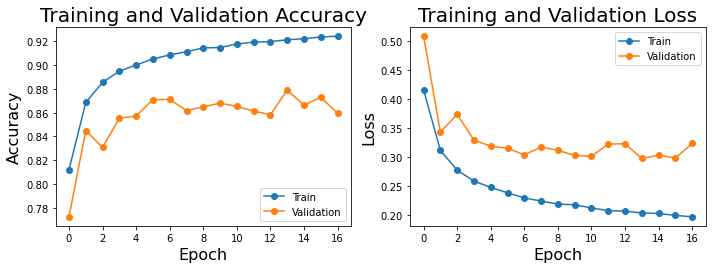

In [24]:
# Plot the training and validation Accuracy and Loss
pcamlib.plot_history(hist_df, save=False, filepath='data/plots/cnn1_history.png')

In [25]:
%%time

# Get predictions from y_proba. Default threshold of 0.5, meaning predicts positive class if >= 50% certainty of class 1 
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 11.6 ms, sys: 1.34 ms, total: 12.9 ms
Wall time: 12.2 ms


In [27]:
%%time

# Calculate accuracy of the predictions on the test set
pcamlib.print_test_accuracy(y_true, y_pred)

0.819732666015625
CPU times: user 4.22 ms, sys: 4.93 ms, total: 9.15 ms
Wall time: 6.96 ms


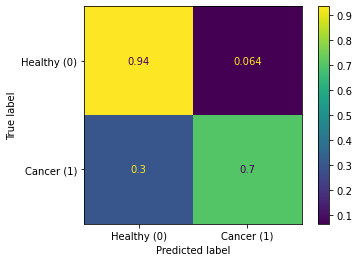

In [28]:
# Plot the confusion matrix
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True, save=False, filepath='data/plots/resnet50_cf_matrix.png')

In [29]:
# Print the classification report to see precision, recall, and f1 score
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7594    0.9362    0.8386     16391
           1     0.9167    0.7032    0.7959     16377

    accuracy                         0.8197     32768
   macro avg     0.8381    0.8197    0.8172     32768
weighted avg     0.8380    0.8197    0.8172     32768



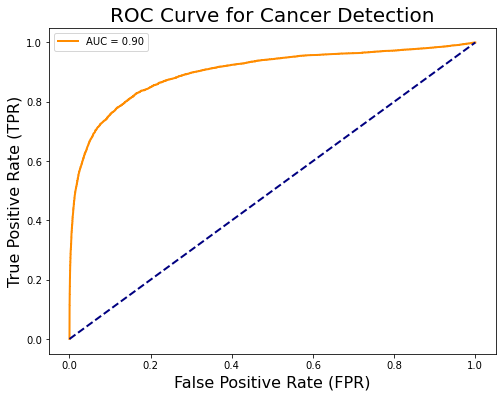

Area under curve (AUC):0.9006396872227812
(8853,)
(8853,)


In [30]:
# Plot the receiver operating characteristic curve
pcamlib.plot_roc_curve(y_true, y_proba, save=False, filepath='data/plots/cnn1_roc.png')

Misclassified Image Indices: 
4
9
10
14
15
19
26
28
33


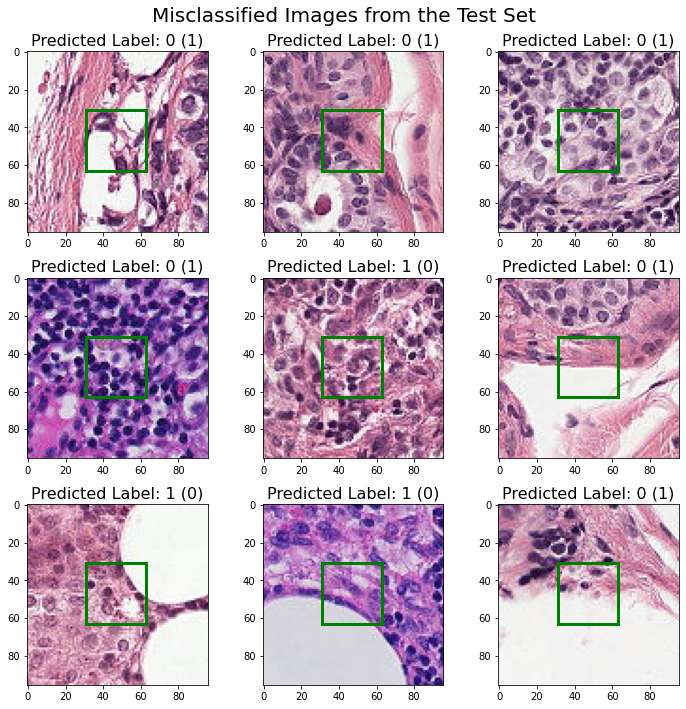

In [31]:
# Show a sample of images that were misclassified
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

----

## Analysis - CNN1.1

In [32]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1.1_history.csv')

In [33]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/cnn1.1_y_proba.csv')

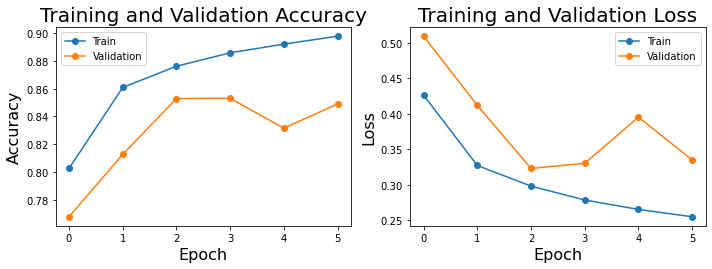

In [34]:
# Plot the training and validation Accuracy and Loss
pcamlib.plot_history(hist_df, save=False, filepath='data/plots/cnn1.1_history.png')

In [35]:
%%time

# Get predictions from y_proba. Default threshold of 0.5, meaning predicts positive class if >= 50% certainty of class 1 
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 10.6 ms, sys: 1.19 ms, total: 11.8 ms
Wall time: 11.2 ms


In [36]:
%%time

# Calculate accuracy of the predictions on the test set
pcamlib.print_test_accuracy(y_true, y_pred)

0.84136962890625
CPU times: user 3.03 ms, sys: 1.07 ms, total: 4.09 ms
Wall time: 2.9 ms


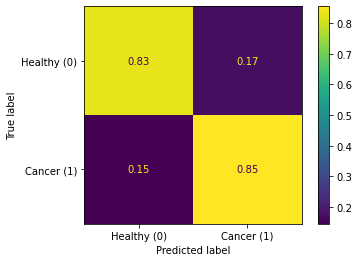

In [37]:
# Plot the confusion matrix
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True, save=True, filepath='data/plots/resnet50_cf_matrix.png')

In [38]:
# Print the classification report to see precision, recall, and f1 score
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.8506    0.8284    0.8393     16391
           1     0.8326    0.8544    0.8433     16377

    accuracy                         0.8414     32768
   macro avg     0.8416    0.8414    0.8413     32768
weighted avg     0.8416    0.8414    0.8413     32768



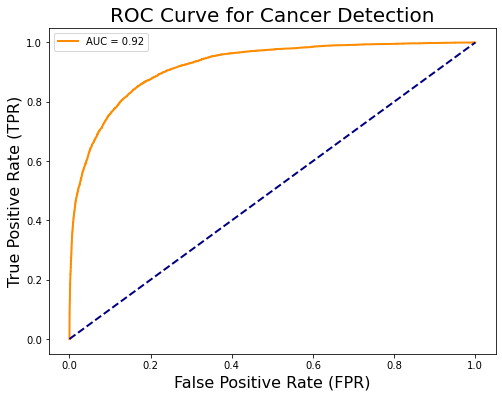

Area under curve (AUC):0.9212465887557078
(8884,)
(8884,)


In [39]:
# Plot the receiver operating characteristic curve
pcamlib.plot_roc_curve(y_true, y_proba, save=False, filepath='data/plots/cnn1.1_roc.png')

Misclassified Image Indices: 
12
14
15
16
20
26
28
32
43


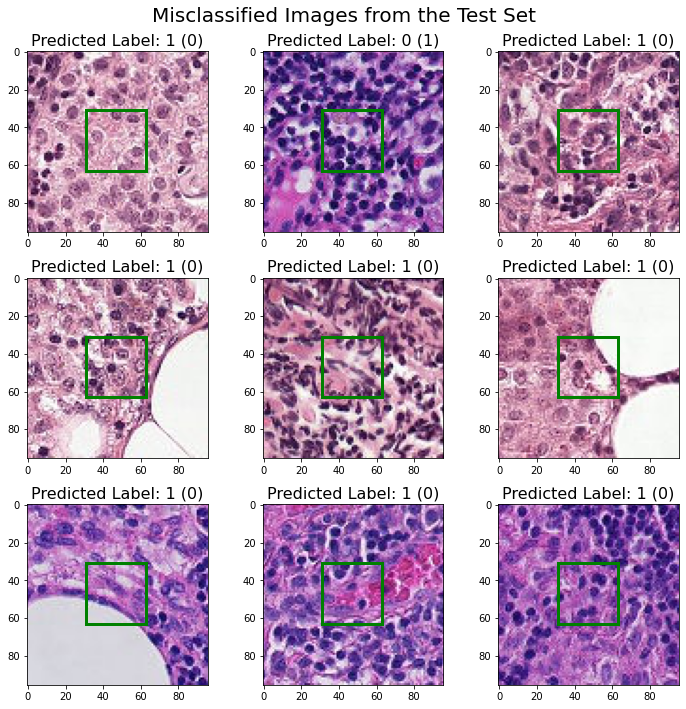

In [40]:
# Show a sample of images that were misclassified
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

----

In [41]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/cnn1.2_history.csv')

In [42]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/y_proba/cnn1.2_y_proba.csv')

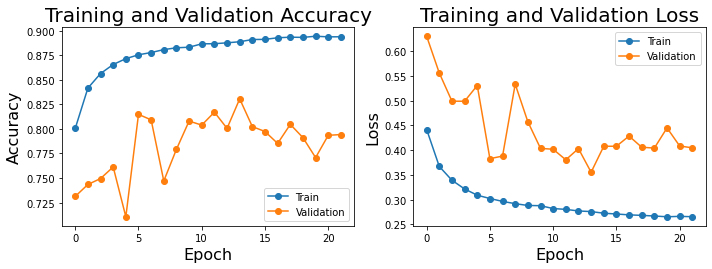

In [43]:
# Plot the training and validation Accuracy and Loss
pcamlib.plot_history(hist_df, save=False, filepath='data/plots/cnn1.2_history.png')

In [44]:
%%time

# Get predictions from y_proba. Default threshold of 0.5, meaning predicts positive class if >= 50% certainty of class 1 
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 12.3 ms, sys: 1.89 ms, total: 14.2 ms
Wall time: 12.8 ms


In [45]:
%%time

# Calculate accuracy of the predictions on the test set
pcamlib.print_test_accuracy(y_true, y_pred)

0.787078857421875
CPU times: user 5.01 ms, sys: 1.82 ms, total: 6.83 ms
Wall time: 4.33 ms


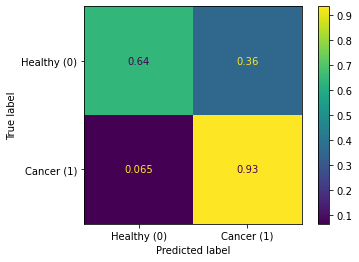

In [46]:
# Plot the confusion matrix
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True, save=True, filepath='data/plots/resnet50_cf_matrix.png')

In [47]:
# Print the classification report to see precision, recall, and f1 score
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.9072    0.6398    0.7504     16391
           1     0.7216    0.9345    0.8144     16377

    accuracy                         0.7871     32768
   macro avg     0.8144    0.7871    0.7824     32768
weighted avg     0.8144    0.7871    0.7824     32768



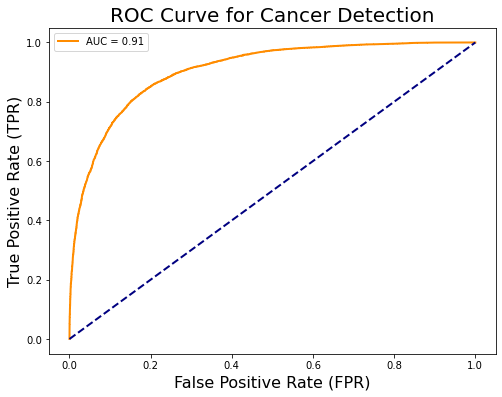

Area under curve (AUC):0.9057863555235096
(9393,)
(9393,)


In [48]:
# Plot the receiver operating characteristic curve
pcamlib.plot_roc_curve(y_true, y_proba, save=False, filepath='data/plots/cnn1_roc.png')

Misclassified Image Indices: 
0
11
12
13
15
16
20
26
28


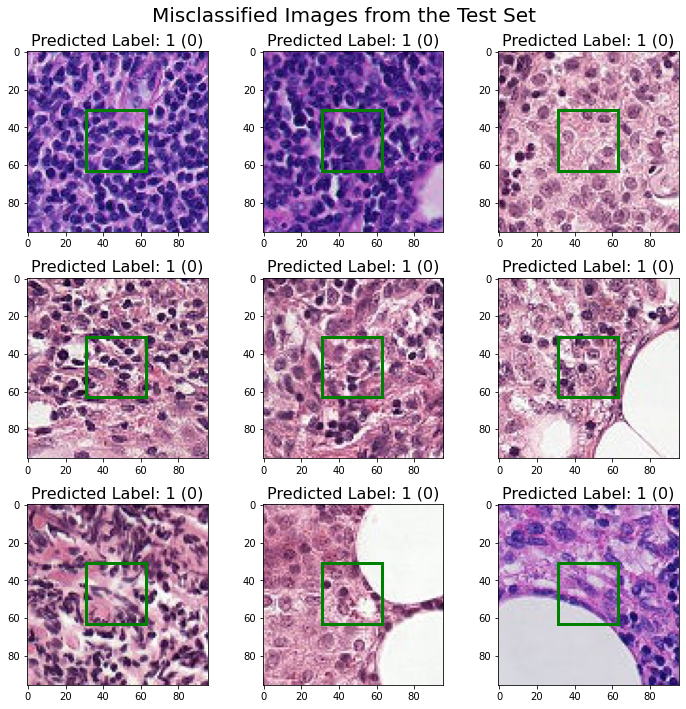

In [49]:
# Show a sample of images that were misclassified
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

## Summary

Training and prediction times calculated in Google Colab Pro with GPU acceleration. These times can vary based on which GPU is allocated during each runtime, and can also vary widely depending on when or if the early stopping condition is met.

Note that test accuracy may vary each time the model is trained due to the random nature of the initial weights and the shuffling of the training set. These are meant to be rough estimates. 

Time permitting, I tried to train each version of the model at least 3 times to establish a range of values for the test accuracy and AUC to account for the randomness in training, and the values for training and prediction time are averaged across the training cycles. However, I saved only the best version of each model to simplify constructing the various plots.

| Model   | Description                                                                                                        | Test Accuracy | AUC       | Mean Training Time | Mean Prediction Time |
|---------|--------------------------------------------------------------------------------------------------------------------|---------------|-----------|--------------------|----------------------|
| CNN 1.0 | Base model adapted from Geert Liljens topology.  Added 20% Dropout layers after each Convolutional and Dense layer | 78.1-82.0%    | 0.85-0.90 | 43 minutes         | 28 seconds           |
| CNN 1.1 | Increased dropout to 25%                                                                                           | 83.0-85.4%    | 0.91-0.93 | 31 minutes         | 42 seconds           |

| Model   | Description                                                                                                        | Test Accuracy | AUC       | Mean Training Time | Mean Prediction Time |
|---------|--------------------------------------------------------------------------------------------------------------------|---------------|-----------|--------------------|----------------------|
| CNN 1.0 | Base model adapted from Geert Liljens topology.  Added 20% Dropout layers after each Convolutional and Dense layer | 78.1-82.0%    | 0.85-0.90 | 43 minutes         | 28 seconds           |
| CNN 1.1 | Increased dropout to 25%                                                                                           | 83.0-85.4%    | 0.91-0.93 | 31 minutes         | 42 seconds           |
| CNN 1.2 | Added 2 additional Convolutional layers of size 128 before the Dense layers                                        |               |           |                    |                      |